In [1]:
import xml.etree.ElementTree as ET
import xml
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from pathlib import Path
from tqdm import tqdm
import shutil
import copy

In [2]:
def image_element_to_image_data(e: xml.etree.ElementTree.Element) -> dict:
    boxes = e.findall('box')
    boxes_data = []

    def to_xy(e) -> dict:
        return {'x': int(e.get('x')), 'y': int(e.get('y'))}
        
    for box in boxes:
        htop = [p for p in box.findall('part') if p.get('name') == 'htop'][0]
        lear = [p for p in box.findall('part') if p.get('name') == 'lear'][0]
        rear = [p for p in box.findall('part') if p.get('name') == 'rear'][0]
        nose = [p for p in box.findall('part') if p.get('name') == 'nose'][0]
        leye = [p for p in box.findall('part') if p.get('name') == 'leye'][0]
        reye = [p for p in box.findall('part') if p.get('name') == 'reye'][0]
        data = {
            "top": int(box.get("top")), 
            "left": int(box.get("left")), 
            "width": int(box.get("width")), 
            "height": int(box.get("height")),
            'parts': {
                'htop': to_xy(htop), 
                'lear': to_xy(lear), 
                'rear': to_xy(rear), 
                'nose': to_xy(nose), 
                'leye': to_xy(leye), 
                'reye': to_xy(reye)
            }
        }
        boxes_data.append(data)

    filepath = base_path / e.get("file")
    
    return {
        "filepath": filepath,
        "bboxes": boxes_data,
    }

def parse_xml(filepath: Path) -> dict:
    tree = ET.parse(label_path)
    root = tree.getroot()
    image_elements = root.find('images').findall('image')
    return {
        "images": [image_element_to_image_data(e) for e in image_elements],
    }

def load_xml(filepath: Path) -> dict:
    xml_data =  parse_xml(label_path)
    
    # Add image size to image_data
    for image_data in xml_data['images']:
        image = Image.open(image_data['filepath'])
        width, height = image.size
        image_data['size'] = {'width': width, 'height': height}
        
    return xml_data

In [3]:
# Heuristics for generating better bboxes

def include_htop_ears_bbox(bbox: dict) -> dict:
    
    bbox_x0y0 = {"x": bbox["left"], "y": bbox["top"]}
    bbox_x1y1 = {"x": bbox["left"] + bbox["width"], "y": bbox["top"] + bbox["height"]}
    
    points = [bbox["parts"]["htop"], bbox["parts"]["lear"], bbox["parts"]["rear"], bbox_x0y0, bbox_x1y1]
    
    new_x0 = min([e.get("x") for e in points])
    new_x1 = max([e.get("x") for e in points])
    new_y0 = min([e.get("y") for e in points])
    new_y1 = max([e.get("y") for e in points])

    width = new_x1 - new_x0
    height = new_y1 - new_y0
    
    new_bbox = {
        "left": new_x0, 
        "top": new_y0, 
        "width": width, 
        "height": height,
        "parts": copy.deepcopy(bbox["parts"]),
    }
    
    return new_bbox


def include_htop_ears_and_margins_bbox(bbox: dict) -> dict:

    margin_bottom_percent = 0.2 # To account for the mouth for instance
    margin_top_percent = 0.2    # To account for the ears
    margin_left_percent = 0.1   # To account for the ears
    margin_right_percent = 0.1  # To account for the ears

    bbox1 = include_htop_ears_bbox(bbox)
    
    new_x0 = bbox1["left"] - margin_left_percent * bbox1["width"]
    new_y0 = bbox1["top"] - margin_top_percent * bbox1["height"]

    new_width = bbox1["width"] + margin_left_percent * bbox1["width"] + margin_right_percent * bbox1["width"]
    new_height = bbox1["height"] + margin_top_percent * bbox1["height"] + margin_bottom_percent * bbox1["height"]

    new_bbox = {
        "left": new_x0, 
        "top": new_y0, 
        "width": new_width, 
        "height": new_height,
        "parts": copy.deepcopy(bbox["parts"]),
    }
    
    return new_bbox

In [5]:
def display_bbox(bbox, ax) -> None:
    
    # Ears
    ax.plot(bbox['parts']["lear"]["x"], bbox['parts']["lear"]["y"], marker='x', color="yellow") 
    ax.plot(bbox['parts']["rear"]["x"], bbox['parts']["rear"]["y"], marker='x', color="yellow")  

    # Head Top
    ax.plot(bbox['parts']["htop"]["x"], bbox['parts']["htop"]["y"], marker='v', color="white") 

    # Nose
    ax.plot(bbox['parts']["nose"]["x"], bbox['parts']["nose"]["y"], marker='o', color="green") 

    # Eyes
    ax.plot(bbox['parts']["leye"]["x"], bbox['parts']["leye"]["y"], marker='x', color="blue") 
    ax.plot(bbox['parts']["reye"]["x"], bbox['parts']["reye"]["y"], marker='x', color="blue")  

    rect = patches.Rectangle(
        (bbox['left'], bbox['top']),
        bbox['width'],
        bbox['height'],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )

    ax.add_patch(rect)
    return ax
    

def display_image_data(image_data):
    image_path = image_data['filepath']
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for bbox in image_data['bboxes']:
        display_bbox(bbox, ax)
    
    plt.show()


def compare_bboxes(image_data, heuristics_bbox_fn1, heuristics_bbox_fn2):
    
    image_path = image_data['filepath']
    img = Image.open(image_path)
    fig, _ = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    ax1, ax2, ax3 = fig.get_axes()

    ax1.imshow(img)
    ax2.imshow(img)
    ax3.imshow(img)
    
    for bbox in image_data['bboxes']:
        display_bbox(bbox, ax1)
        display_bbox(heuristics_bbox_fn1(bbox), ax2)
        display_bbox(heuristics_bbox_fn2(bbox), ax3)
    
    plt.show()

In [6]:
base_path = Path('../../data/01_raw/BearID/')
label_path = base_path / 'images_train_without_bc.xml'

In [7]:
xml_data = load_xml(label_path)

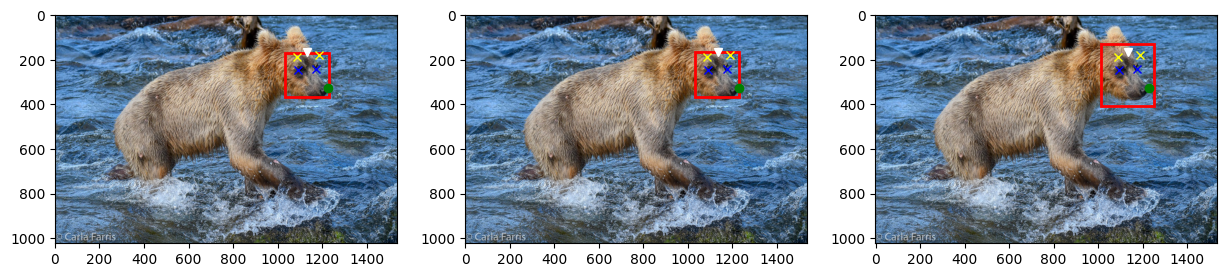

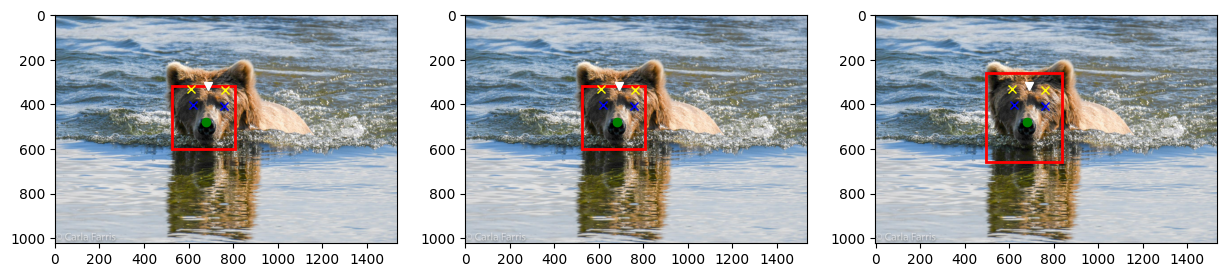

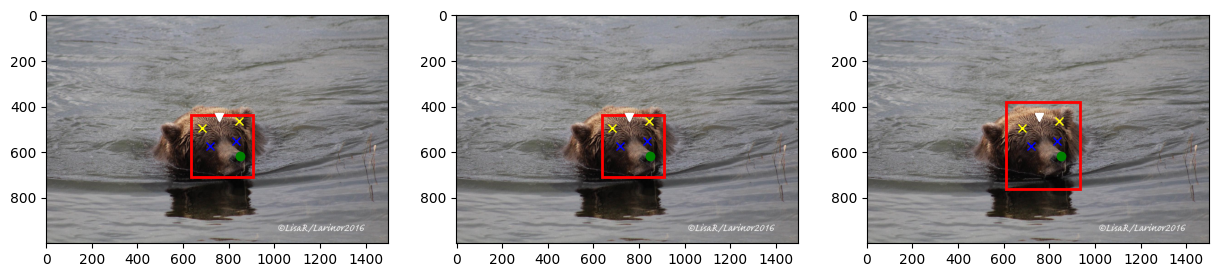

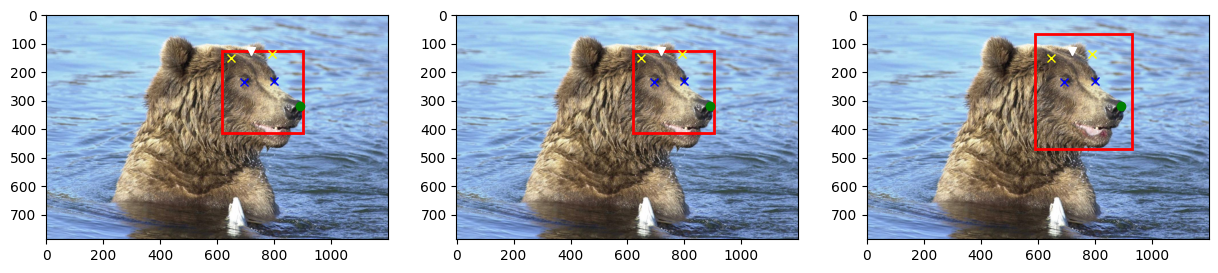

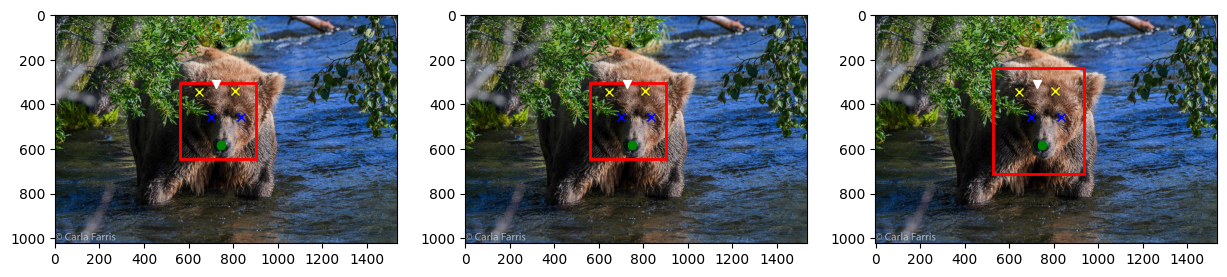

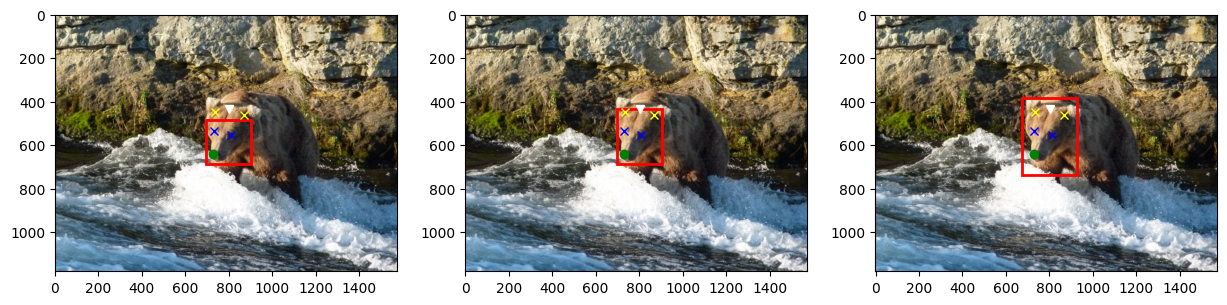

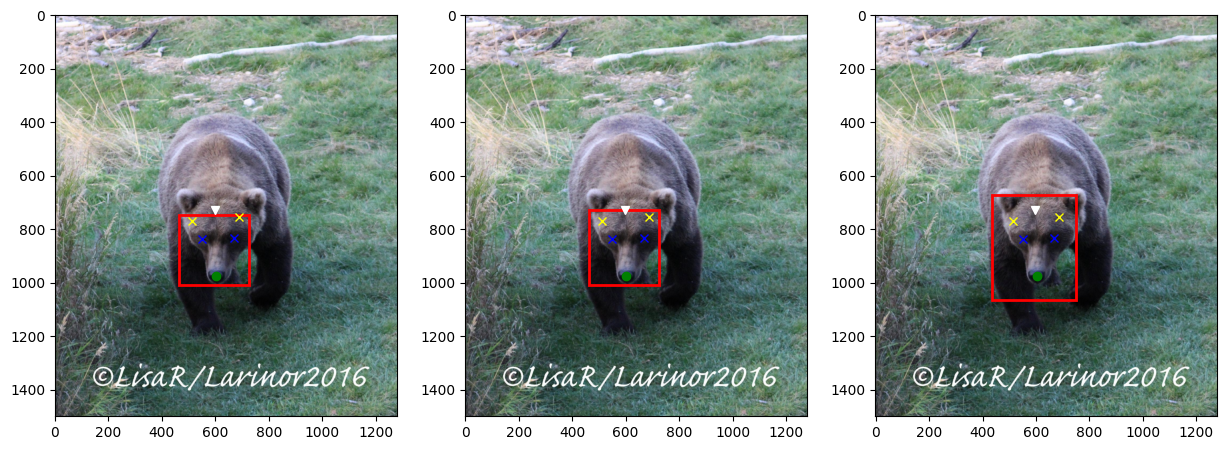

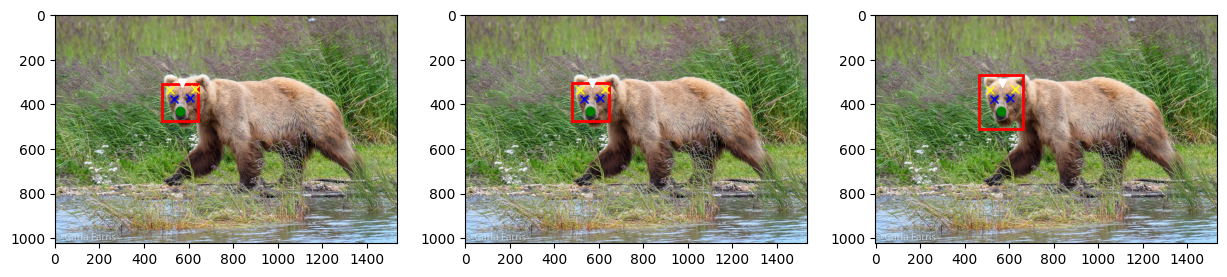

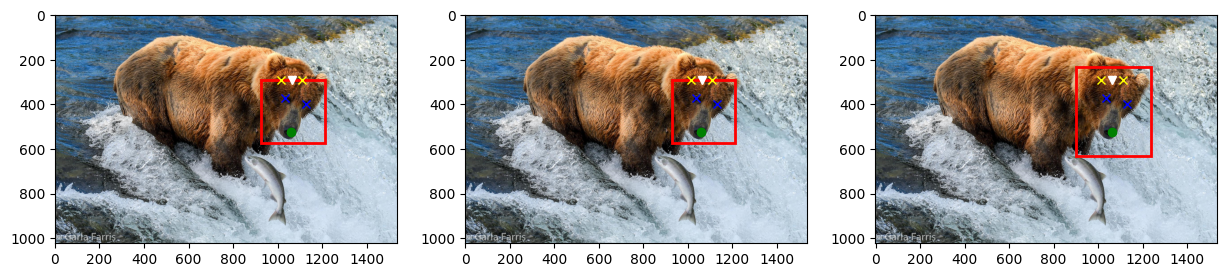

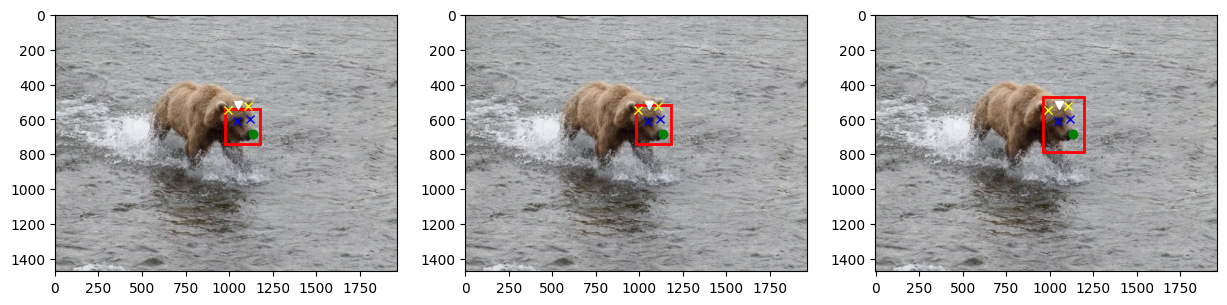

In [9]:
random.seed(42)
N_samples = 10

for _ in range(N_samples):
    idx = random.randint(0, len(xml_data['images']))
    compare_bboxes(
        image_data=xml_data['images'][idx], 
        heuristics_bbox_fn1=include_htop_ears_bbox,
        heuristics_bbox_fn2=include_htop_ears_and_margins_bbox,
    )